<h1><center> <ins><b> K-Means Clustering Visualisation Code </b></ins></center></h1>

For the purposes of visualising this algorithm, we will strictly be working with 2-dimensional datasets in order to make plotting easier.

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import random
from sklearn.cluster import KMeans
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [2]:
# This function will help us visualise the process of the centroids being chosen out of all datapoints

def CentroidPlot(data, centroids):
    
    # Plot all datapoints
    plt.figure(figsize=(12,8))
    plt.scatter(data['col1'], data['col2'], marker='o',
                color='gray', label='Data Points')
    # Plot the old centroids already defined
    plt.scatter(centroids[:-1, 0], centroids[:-1, 1],
                color='black', label='Previous Centroids', s=100)
    # Plot the new centroid that has just been defined
    plt.scatter(centroids[-1, 0], centroids[-1, 1],
                color='red', label='Current Centroid', s=100)
    
    # Adjustments to plot
    plt.xlabel('x', fontsize=25)
    plt.ylabel('y', fontsize=25)
    plt.title('Selecting centroid %d' % (centroids.shape[0]), fontsize=40)
    plt.legend()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.show()

In [3]:
# This function returns the euclidean distance between 2 points. We define it here to avoid having to write it everywhere below

def distance(p1,p2):
    return np.sqrt(np.sum((p1 - p2)**2))

In [4]:
# This function will initialise our first set of centroids through a K-Means++ implementation

def InitCentroids(data,k):
    # Seed for reproducibility of results
    random.seed(0)
    
    # Initialise our array of centroids
    centroids = []
    # We will take our first centroid to be any random datapoint within our dataframe
    centroids.append(data.loc[random.randint(0,len(data)+1), :'col2'].to_numpy())
    # Call our plot function
    CentroidPlot(data, np.array(centroids))
    
    # CHANGE INTO 2D ARRAY SINCE WE DO NOT NEED TO TABULATE/DISPLAY DISTANCES
    # We will make a dataframe to store distances of points from centroids so we can call from it instead of calculating each distance every time
    distances = pd.DataFrame()
    
    for a in range(k-1):
        # Initialise and store all distances from all points to a centroid
        d=[]
        for i in range(len(data)):
            d.append(distance(np.array(data.loc[i, :'col2']),centroids[a]))
        distances[f'd{a+1}'] = d
        
        # Here we isolate the case where we only have 1 predefined centroid since we do not need to take the minimum of multiple distances
        if a == 0:
            # Find our constant in our weighted probability distribution (explained in previous notebook)
            c = 1/(np.sum(distances['d1']**2))
            w = c*(distances['d1']**2)
            # Use this weighted probability distribution to choose the next centroid
            temp = int(random.choices(population=np.linspace(0,len(data)-1,len(data)),weights=w,k=1)[0])
            centroids.append(np.array(data.iloc[temp,:2]))
            # Call our initial centroid plotting function
            CentroidPlot(data.iloc[:,:2], np.array(centroids))
        
        # Here we deal with the case where we have multiple predefined centroids
        else:
            # Take the minimum of all distances
            distances['mins'] = distances[list(distances.columns)].min(axis=1)
            # Find our constant in our weighted probability distribution (explained in previous notebook)
            c = 1/(np.sum(distances['mins']**2))
            w = c*(distances['mins']**2)
            # Use this weighted probability distribution to choose the next centroid
            temp = int(random.choices(population=np.linspace(0,len(data)-1,len(data)),weights=w,k=1)[0])
            centroids.append(np.array(data.iloc[temp,:2]))
            # Drop the minimum distance column so it does not affect future calculations
            distances.drop(['mins'],axis=1,inplace=True)
            # Call our initial centroid plotting function
            CentroidPlot(data.iloc[:,:2], np.array(centroids))
    
    # We can quickly sort our centroids by their y-values or however we want to sort our cluster order in the future
    centroids = sorted(centroids, reverse=True, key=lambda k: k[1])

    return centroids

In [5]:
# This function will perform the K-Means Algorithm and assign each data point a cluster

def KMeansCluster(data, centroids, k):
    
    # Initialize clusters list
    clusters = [[] for _ in range(k)]
    
    # Loop until convergence
    # Initialise our current iteration and maximum iterative value
    max_iter = 50
    iteration = 0
    # Initialise our old centroids so we can check for equality in our while statement
    old_centroids = [[0]*2 for _ in range(k)]
    while np.any(np.not_equal(centroids,old_centroids)) and iteration < max_iter:

        # Clear previous clusters and initiliase array to store cluster values
        clusters = [[] for _ in range(k)]
        temptemp=[]
        
        # Assign each point to the closest centroid and store which cluster it belongs to
        for point in np.array(data.iloc[:,:2]):
            distances_to_each_centroid = [distance(point, centroid) for centroid in centroids]
            cluster_assignment = np.argmin(distances_to_each_centroid)
            temptemp.append(cluster_assignment)
            clusters[cluster_assignment].append(point)
        
        # Assign old centroids as centroids for comparison in our while statement
        old_centroids = centroids
        # Calculate new centroids by taking the mean of all points within a respective cluster
        new_centroids = [np.array(np.mean(cluster,axis=0)) for cluster in clusters]
        # Assign centroids as these new centroids
        centroids = new_centroids
        # Increase iteration by 1
        iteration += 1
    
    # Write the corresponding cluster for each datapoint in our dataframe
    data['cluster'] = temptemp
    print('The centroids are', np.array(centroids).tolist())
    print('\nResults achieved on iteration', iteration)
    return centroids

In [6]:
# This function will plot our Voronoi Diagram

def VoronoiPlot(data, centroids, k):
    
    # Add outlier points to our centroids so we can colour our plot easier in the future
    centroids2 = np.append(centroids, [[999,999], [-999,999], [999,-999], [-999,-999]], axis=0)
    
    # Plot inital voronoi diagram
    vor = Voronoi(centroids2)
    fig,ax = plt.subplots(1,1,figsize=(12, 8))
    voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False)

    # We will remove the extra regions that we do not need
    regions=[]
    for region in vor.regions:
        if not -1 in region:
            regions.append(region)
    regions = [x for x in regions if x != []]

    # When running the initial voronoi diagram, the regions are not in the same order as our centroids
    # So we will find which regions our centroid are in and order our regions correctly at the end
    order=[]
    for i in range(k):
        for j in range(k):
            point = Point(centroids[i])
            shape = Polygon([vor.vertices[v] for v in regions[j]])
            if shape.contains(point) == True:
                break
        order.append(j)
    regions = [regions[i] for i in order]

    # Colour the regions for easy visualisation
    color = list(cm.rainbow(np.linspace(0, 1, k)))
    for a,region in enumerate(regions):
        polygon = [vor.vertices[i] for i in region]
        ax.fill(*zip(*polygon),color=color[a],alpha=0.25)
    
    # Plot the datapoints with varying colours based on which cluster it belongs to
    for i in range(k):
        ax.scatter(data[data['cluster']==i]['col1'], data[data['cluster']==i]['col2'], marker='o',
                    color=color[i], edgecolors='black', label=f'points for cluster {i}', s=30)
    # Plot the centroids
    ax.scatter(np.array(centroids)[:, 0], np.array(centroids)[:, 1], marker='X',
                color='black', edgecolors='black', label='centroids', s=100)
    
    # Last touches to our plot
    plt.xlabel('x', fontsize=18)
    plt.ylabel('y', fontsize=18)
    plt.title('Visualising our K-Means Clustering Algorithm', fontsize=25)
    plt.legend()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.show()

In [7]:
# Creating data
np.random.seed(0)
mean_01 = [0.0, 0.0]
cov_01 = [[1, 0.3], [0.3, 1]]
dist_01 = np.random.multivariate_normal(mean_01, cov_01, 250)

mean_02 = [6.0, 7.0]
cov_02 = [[1.5, 0.3], [0.3, 1]]
dist_02 = np.random.multivariate_normal(mean_02, cov_02, 250)

mean_03 = [7.5, -5.0]
cov_03 = [[0.8, 0.5], [0.5, 1]]
dist_03 = np.random.multivariate_normal(mean_03, cov_01, 250)

mean_04 = [1.0, -7.0]
cov_04 = [[1.0, 0.5], [0.5, 1.3]]
dist_04 = np.random.multivariate_normal(mean_04, cov_01, 250)

data = np.vstack((dist_01, dist_02, dist_03, dist_04))
np.random.shuffle(data)
data = pd.DataFrame(data)
data.rename(columns={0: 'col1', 1: 'col2'}, inplace=True)
#data.to_csv('/Users/Sajeeth/Documents/Quant Portfolio/Machine Learning Projects/K-Means Clustering/Data.csv', encoding='utf-8', index=False, header=True)
data

,col1,col2
0,1.685464,0.005276
1,-1.658961,-1.185488
2,0.679986,-5.880540
3,4.178174,4.497586
4,2.560494,-7.381996
...,...,...
995,6.337033,6.055192
996,3.781123,4.651209
997,7.630637,-6.109575
998,5.961079,-6.091951


In [8]:
# Find the min and max values of each column for our plots later
xmin,xmax = data['col1'].agg(['min', 'max'])
ymin,ymax = data['col2'].agg(['min', 'max'])
xmin,ymin = (np.floor(x)-1 for x in (xmin,ymin))
xmax,ymax = (np.ceil(x)+1 for x in (xmax,ymax))

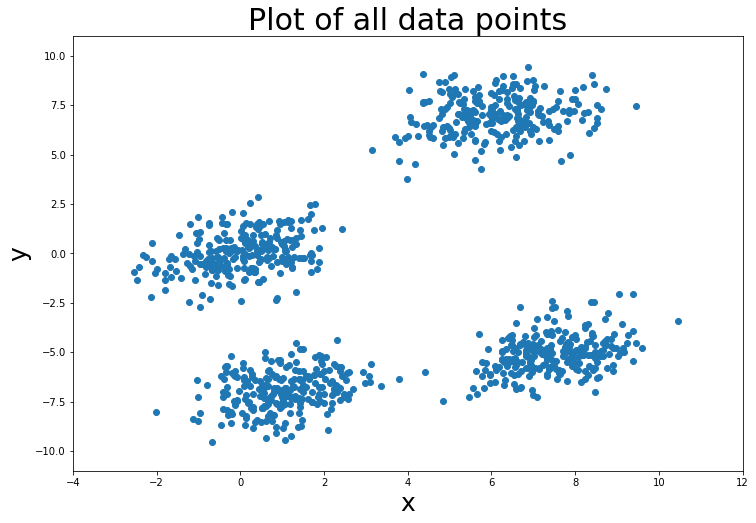

In [9]:
# Plot the data to see what we are working with
plt.figure(figsize=(12,8))
plt.scatter(data['col1'], data['col2'], cmap='viridis', marker='o')
plt.xlabel('x', fontsize=25)
plt.ylabel('y', fontsize=25)
plt.title('Plot of all data points', fontsize=30)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

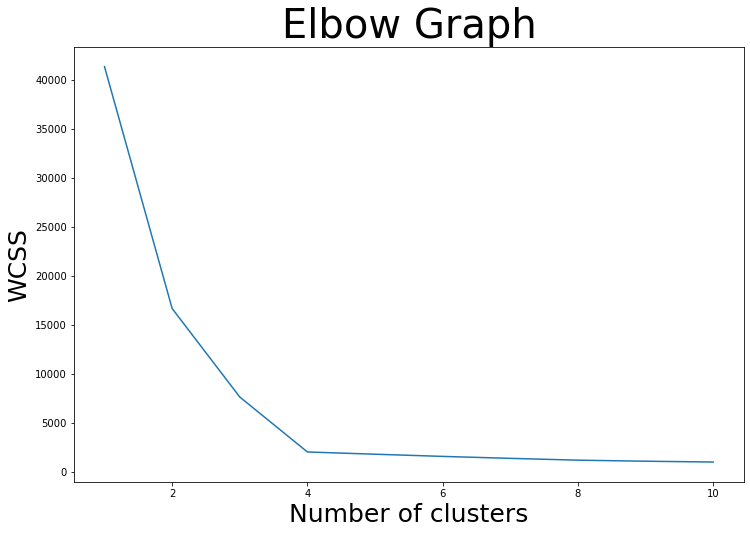

In [10]:
# Plotting Elbow Graph
cs = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(data)
    cs.append(kmeans.inertia_)

plt.figure(figsize=(12,8))
plt.plot(range(1, 11), cs)
plt.title('Elbow Graph', fontsize = 40)
plt.xlabel('Number of clusters', fontsize = 25)
plt.ylabel('WCSS', fontsize = 25)
plt.show()

## Clearly, looking at the plot of all data points by eye, there are 4 clusters. This is further supported by our Elbow Graph which has an elbow at k=4. <br>Thus, let us continue with k=4 

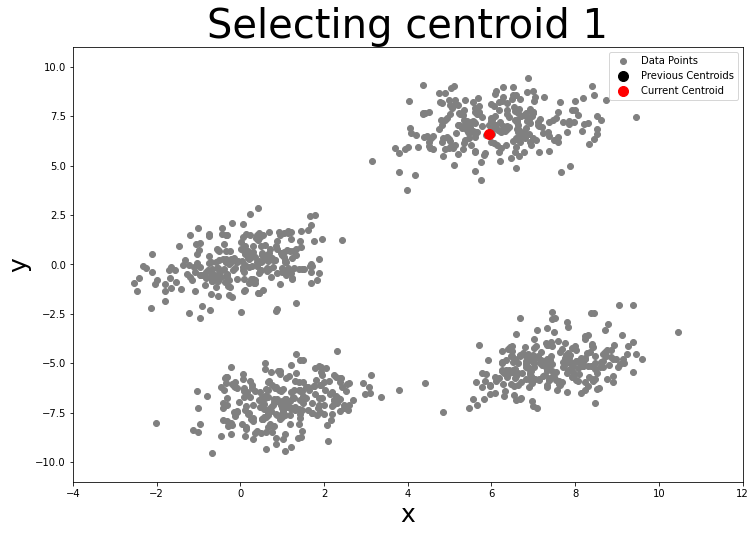

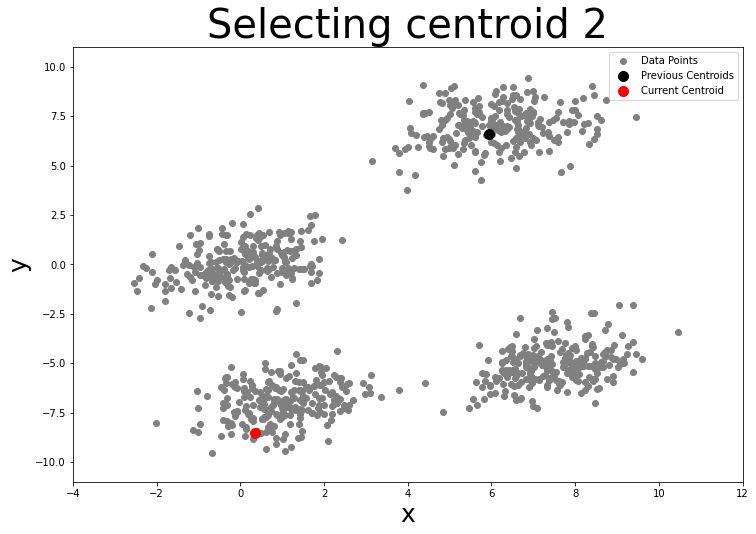

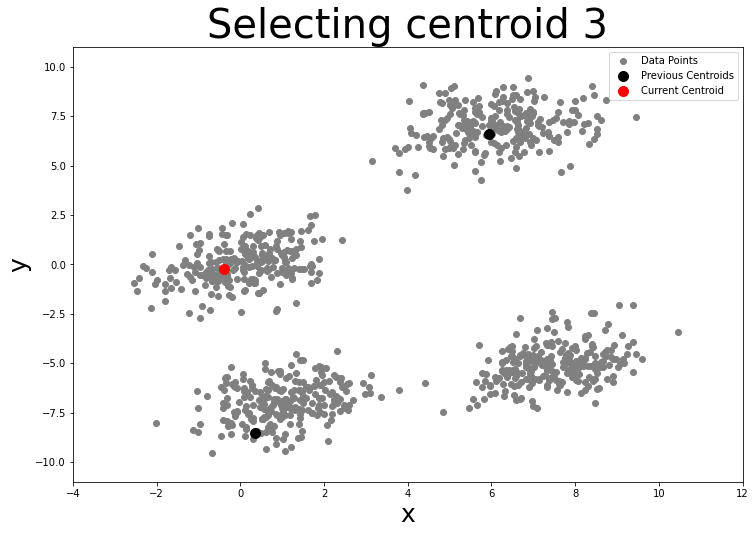

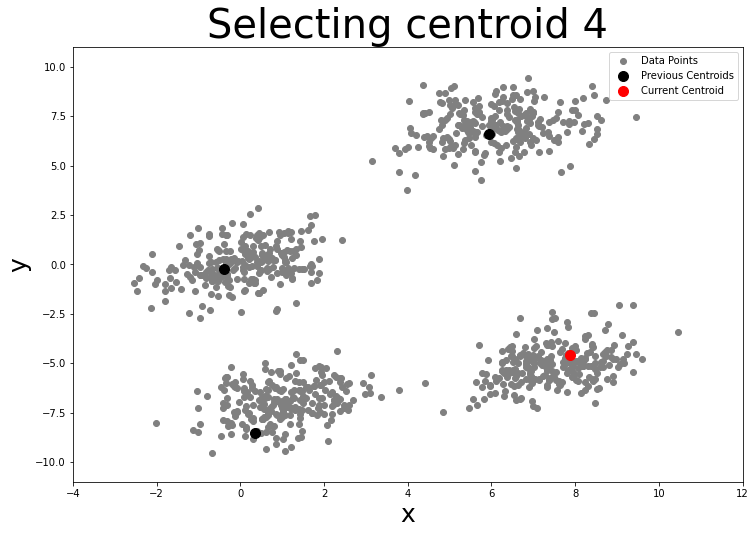

In [11]:
centroids = InitCentroids(data,4)

In [12]:
centroids2 = KMeansCluster(data,centroids,4)

The centroids are [[6.110504815651851, 6.997476262162707], [0.041468145587098805, 0.04469520477329504], [7.44713023710177, -5.084796293215528], [1.0112490664052882, -6.9441849087356]]

Results achieved on iteration 2


## Now, we will plot our Voronoi Diagram with our initial set of centroids

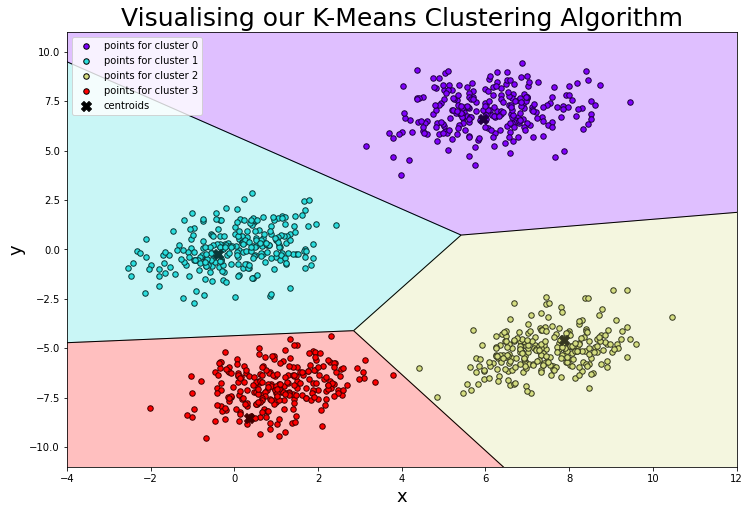

In [13]:
VoronoiPlot(data,centroids,4)

## To compare, we will now plot our Voronoi Diagram with our final set of centroids

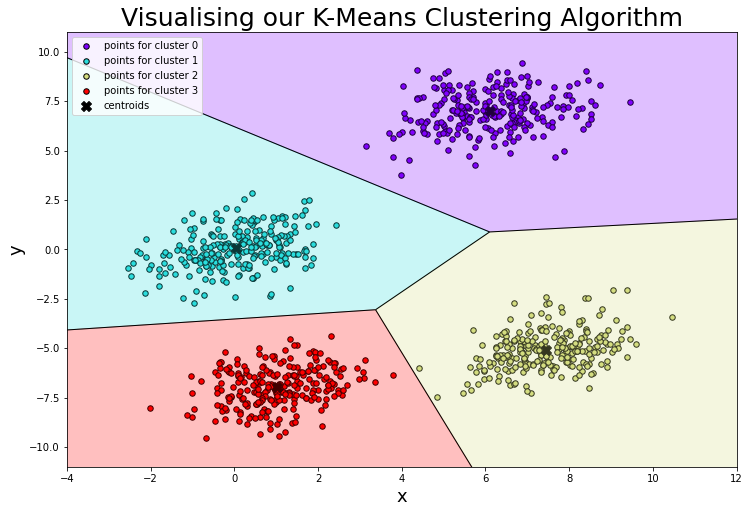

In [14]:
VoronoiPlot(data,centroids2,4)

## Finally, let us see our clustered data

In [15]:
data

,col1,col2,cluster
0,1.685464,0.005276,1
1,-1.658961,-1.185488,1
2,0.679986,-5.880540,3
3,4.178174,4.497586,0
4,2.560494,-7.381996,3
...,...,...,...
995,6.337033,6.055192,0
996,3.781123,4.651209,0
997,7.630637,-6.109575,2
998,5.961079,-6.091951,2
